In [1]:
%matplotlib inline
import numpy as np
import bettermoments as bm
import matplotlib.pyplot as plt
from imgcube.cube import imagecube
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm
plt.style.use('paper')

In [2]:
# read in the data
cube = imagecube('HD135344B_13CO.fits', clip=1.5)
velax, data = cube.velax, cube.data

In [3]:
# calculate contour of 3% of peak integrated intensity for plotting
# using a 3 sigma clip.
rms = np.nanstd([data[:3], data[-3:]])
clip = 3. * rms
zeroth = np.sum(np.where(np.abs(data) >= clip, data, 0.0), axis=0)
zeroth /= np.max(zeroth)

In [4]:
# calculate the intensity weighted average, clipping at 2 sigma.
# include some smaller scatter as weights can't sum to zero.
clip = 2. * rms
weights = np.where(np.abs(data) >= clip, data, 1e-10 * np.random.randn(data.size).reshape(data.shape))
velocities = velax[:, None, None] * np.ones(data.shape)
v_first = np.average(velocities, weights=weights, axis=0)

In [5]:
# calculate the velocity of the peak pixels.
v_ninth = np.take(velax, np.argmax(data, axis=0))

In [6]:
# calculate the velocity with better moments.
v_quadratic = bm.quadratic(data, axis=0, x0=velax[0], dx=np.diff(velax).mean())[0]

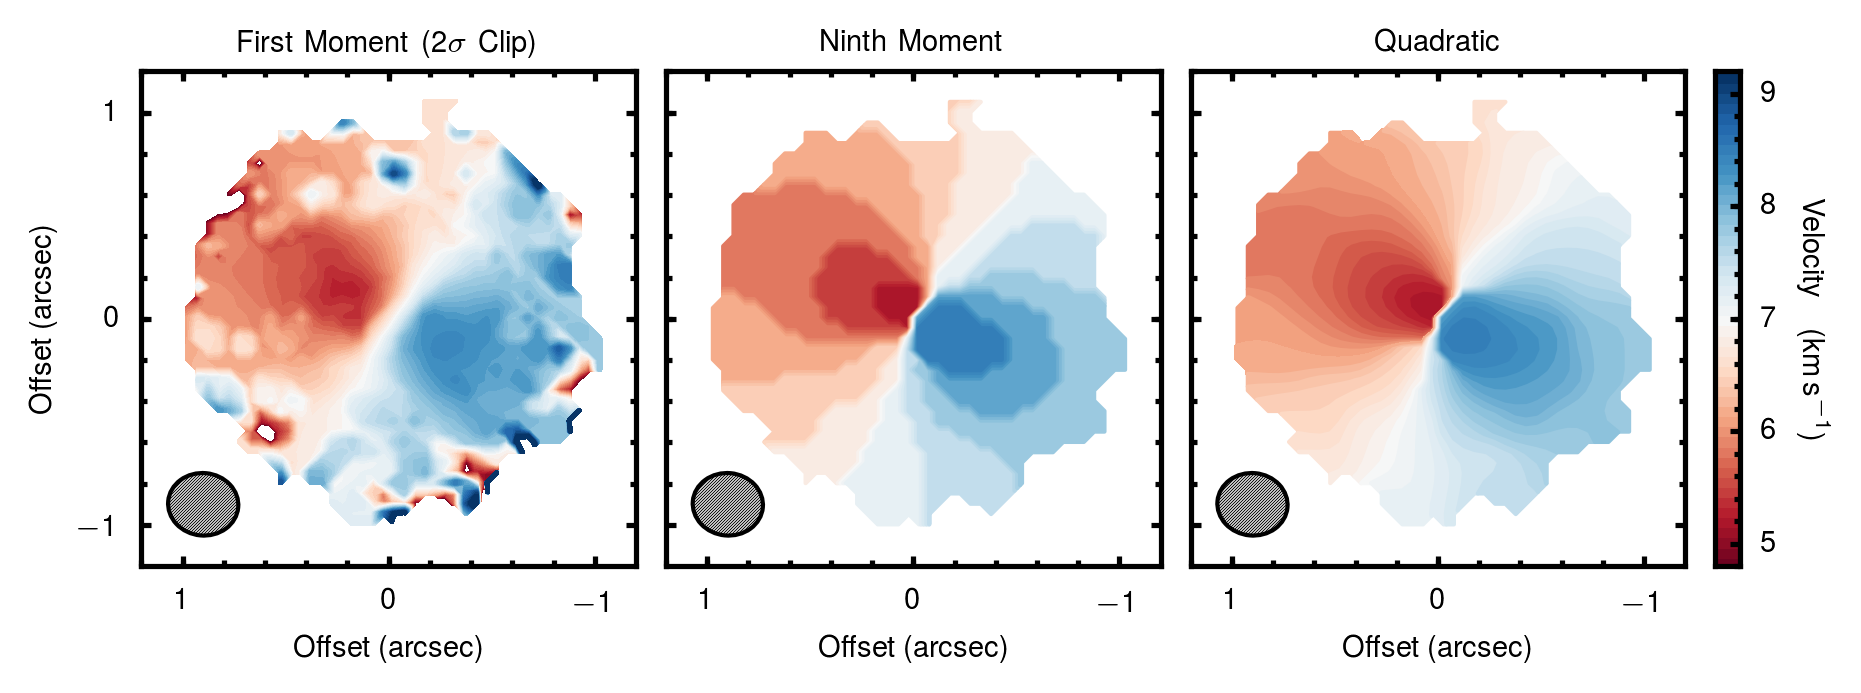

In [7]:
# make the plot.
fig = plt.figure(figsize=(6.0, 2.5))
axs = AxesGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.1, share_all=True,
               label_mode="L", cbar_location="right", cbar_mode="single", cbar_pad=0.1)
labels = [r'${\rm First \,\, Moment \,\, (2\sigma \,\, Clip)}$',
          r'${\rm Ninth \,\, Moment}$',
          'Quadratic']

for ax, mom, label in zip(axs, [v_first, v_ninth, v_quadratic], labels):
    
    im = ax.contourf(cube.xaxis - 0.1, cube.yaxis - 0.07, np.where(zeroth >= 0.05, mom / 1e3, np.nan),
                     levels=np.linspace(4.8, 9.2, 50), cmap=cm.RdBu)
    for c in im.collections:
        c.set_edgecolor("face")
    ax.set_aspect(1)
    ax.set_xlim(1.2, -1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.xaxis.set_major_locator(MultipleLocator(1.0))
    ax.yaxis.set_major_locator(MultipleLocator(1.0))
    
    ax.set_xlabel(r'Offset (arcsec)')
    ax.set_ylabel(r'Offset (arcsec)')
    ax.set_title(label, fontsize=7)
    
    cube.plotbeam(ax=ax, color='k')
    
cb = axs.cbar_axes[0].colorbar(im)
cb.solids.set_edgecolor("face")
axs.cbar_axes[0].set_ylabel(r'${\rm Velocity \quad (km\,s^{-1})}$', rotation=270., labelpad=13)
plt.tight_layout()
plt.savefig('moment_comparison.pdf', bbox_inches='tight')